In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from IPython import display
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, ReLU, Lambda, Flatten

In [2]:
dataset = tf.keras.datasets.mnist.load_data()

(train_images, train_label), (test_images, test_label) = dataset

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]


test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [126]:
# Define the custom PixelShuffle-like layer using tf.nn.space_to_depth
def PixelShuffle(scale):
    return Lambda(lambda x: tf.nn.space_to_depth(tf.reshape(x, (-1, 2, 2, 4)), scale))

In [127]:
def generator_model():
    '''
    Description: This function creates a generator model for a Generative Adversarial Network (GAN).
    The generator model generates new, synthetic data that resembles some known data distribution.

    Input:
    This function does not take any input.

    Output:
    The function returns a Sequential model that consists of several layers of neural networks.

    The model takes a 100-dimensional noise vector as input and outputs a 28x28 grayscale image.
    '''
    # Create a Sequential model
    model = Sequential()

    # Layer 1: Fully Connected
    model.add(Dense(512, input_shape=(64,)))
    model.add(ReLU())
    model.add(BatchNormalization())

    # Layer 2: Fully Connected
    model.add(Dense(64))
    model.add(ReLU())
    model.add(BatchNormalization())

    # Layer 3: PixelShuffle-like using space_to_depth
    model.add(PixelShuffle(scale=2))  # Assuming PixelShuffle with scale factor 2

    # Layer 4: Convolutional
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())

    # Layer 5: PixelShuffle-like using space_to_depth
    model.add(PixelShuffle(scale=2))  # Assuming PixelShuffle with scale factor 2

    # Layer 6: Convolutional
    model.add(Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu'))

    return model

In [128]:
def discriminator_model():
    """
    Returns a discriminator model using Convolutional Neural Network (CNN) architecture.

    Input:
    This function does not take any input.

    Returns:
    model : Sequential model representing the discriminator
    """
    # Create a Sequential model
    model = Sequential()

    # Layer 1: Convolutional
    model.add(Conv2D(32, kernel_size=(4, 4), strides=(2, 2), padding='same', activation='relu', input_shape=(1, 1, 1)))

    # Layer 2: Convolutional
    model.add(Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', activation='relu'))

    # Flatten the output of the previous layer
    model.add(Flatten())

    # Layer 3: Linear
    model.add(Dense(512, activation='relu'))

    # Layer 4: Linear
    model.add(Dense(1))

    return model

In [129]:
def non_saturating(d_real_logits, d_fake_logits):
    """Returns the discriminator and generator loss for Non-saturating loss.

    Args:
      d_real_logits: logits for real points, shape [batch_size, 1].
      d_fake_logits: logits for fake points, shape [batch_size, 1].

    Returns:
      A tuple consisting of the discriminator loss and the generator's loss.
    """
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_real_logits, labels=tf.ones_like(d_real_logits)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_fake_logits, labels=tf.zeros_like(d_fake_logits)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_fake_logits, labels=tf.ones_like(d_fake_logits)))
    return d_loss, g_loss

In [130]:
generator = generator_model()

In [131]:
generator.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 512)               33280     
                                                                 
 re_lu_18 (ReLU)             (None, 512)               0         
                                                                 
 batch_normalization_25 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dense_29 (Dense)            (None, 64)                32832     
                                                                 
 re_lu_19 (ReLU)             (None, 64)                0         
                                                                 
 batch_normalization_26 (Ba  (None, 64)                256       
 tchNormalization)                                   

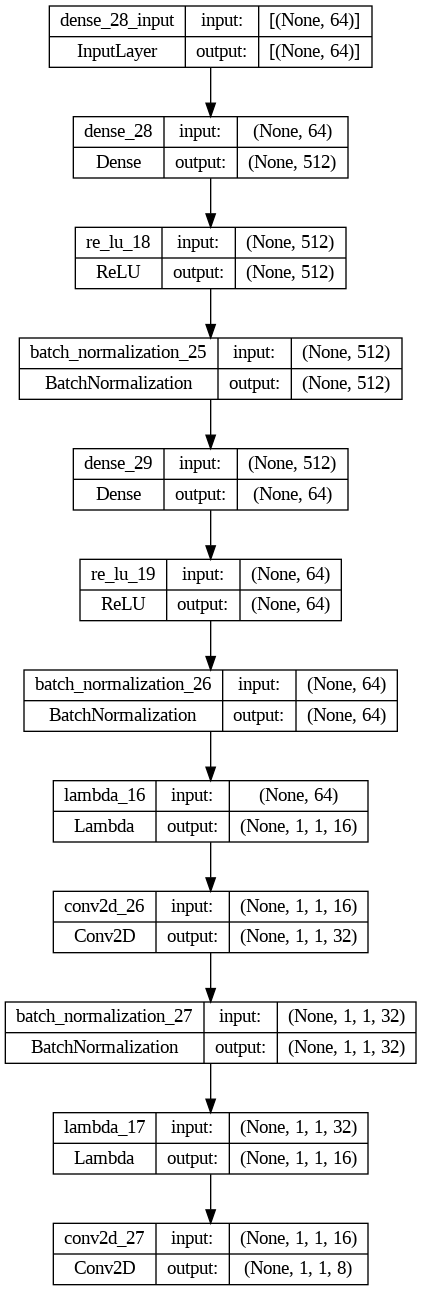

In [132]:
plot_model(generator, show_shapes=True)

In [133]:
discriminator = discriminator_model()

In [134]:
discriminator.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 1, 1, 32)          544       
                                                                 
 conv2d_29 (Conv2D)          (None, 1, 1, 64)          32832     
                                                                 
 flatten_5 (Flatten)         (None, 64)                0         
                                                                 
 dense_30 (Dense)            (None, 512)               33280     
                                                                 
 dense_31 (Dense)            (None, 1)                 513       
                                                                 
Total params: 67169 (262.38 KB)
Trainable params: 67169 (262.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


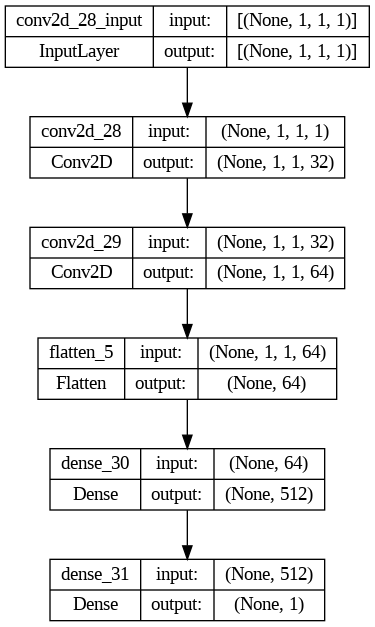

In [135]:
plot_model(discriminator, show_shapes=True)

In [136]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [137]:
EPOCHS = 5
noise_dim = 64

In [138]:
@tf.function
def train_step(images):
    """
    Performs a single training step on the GAN model.

    Args:
        images: A batch of real images.

    Returns:
        None - Applying gradient to the trainable variables of the
        generator and discriminator models using the Adam optimizer
    """
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss,disc_loss = non_saturating(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [139]:
def generate_images(model, epoch, test_input):
    """
    Generate and save images using the generator model.

    Args:
        - model: generator model
        - epoch (int): current epoch number
        - test_input: input noise for the generator model

    Returns:
        None

    Notice `training` is set to False.
    This is so all layers run in inference mode (batchnorm).
    """
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

In [140]:
seed = tf.random.normal([16, noise_dim])

In [141]:
def train(dataset, epochs):
  """
  Trains the Generative Adversarial Network (GAN) model for the specified number of epochs.

  Args:
      - dataset: The input dataset used for training.
      - epochs (int): The number of epochs to train the model.

  Returns:
      None
  """
  for epoch in range(epochs):

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_images(generator,
                             epoch + 1,
                             seed)

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_images(generator,
                           epochs,
                           seed)

In [142]:
train(train_dataset, EPOCHS)

ValueError: in user code:

    File "<ipython-input-28-bf31a51dfcbf>", line 18, in train_step  *
        real_output = discriminator(images, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_16" is incompatible with the layer: expected shape=(None, 1, 1, 1), found shape=(32, 28, 28, 1)
